# Predicting Glovo's orders for Barcelona

The aim of this notebook is to show an example of how to predict Glovo's hourly orders for the next week (iteratively) using machine learning methods.

This notebook covers the next stages:
- Configuration
- Exploratory data analysis (EDA)
- Predictions
    - Baseline predictions
    - ARIMA
    - Radom Forest - Feature creation

## Configuration

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
#sns.set_theme(style="white", palette="pastel")
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

from datetime import datetime, timedelta

from statsmodels.tsa.seasonal import STL

from sklearn.model_selection import TimeSeriesSplit

In [2]:
#!pip install pmdarima
from pmdarima.arima import auto_arima

In [3]:
df = pd.read_csv('data/data_BCN.csv')
df['time'] = pd.to_datetime(df["time"])
print(df.shape)
print(df.info())
df.head()

(8766, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    8766 non-null   datetime64[ns]
 1   orders  8766 non-null   float64       
 2   city    8766 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 205.6+ KB
None


time  orders city
0 2021-02-01 00:00:00     0.0  BCN
1 2021-02-01 01:00:00     0.0  BCN
2 2021-02-01 02:00:00     0.0  BCN
3 2021-02-01 03:00:00     0.0  BCN
4 2021-02-01 04:00:00     0.0  BCN

In [4]:
print(df['time'].min(), df['time'].max())

2021-02-01 00:00:00 2022-02-01 23:00:00


One year of Glovo orders (hourly) starting at february 1st 2021

# EDA

Distribution of the number of orders per hour

count    5988.000000
mean      107.079259
std       120.067663
min         0.700000
25%        28.000000
50%        61.000000
75%       151.000000
max       939.000000
Name: orders, dtype: float64

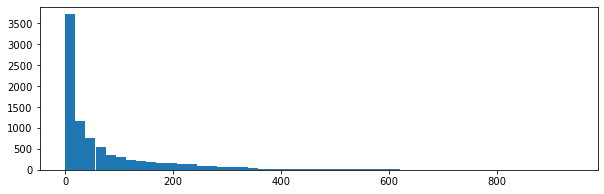

In [5]:
fig, ax = plt.subplots(figsize=(10, 3))
_ = ax.hist(df["orders"], bins=50)
df.loc[df['orders'] > 0, "orders"].describe()

Right skewed distribution: there are many hours in which the number of orders is very low and few times in which the number of orders is quite large

Time series plot of the orders

In [6]:
px.line(df.reset_index(), x="time", y="orders", title="Globo orders by hour (BCN)")

Monthly, weekly and daily trends of orders

In [7]:
df.set_index('time', inplace=True)

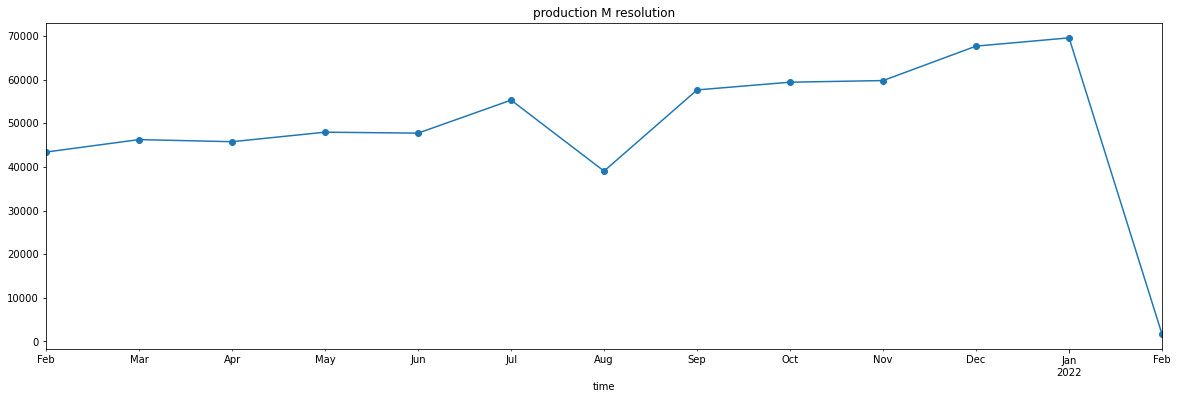

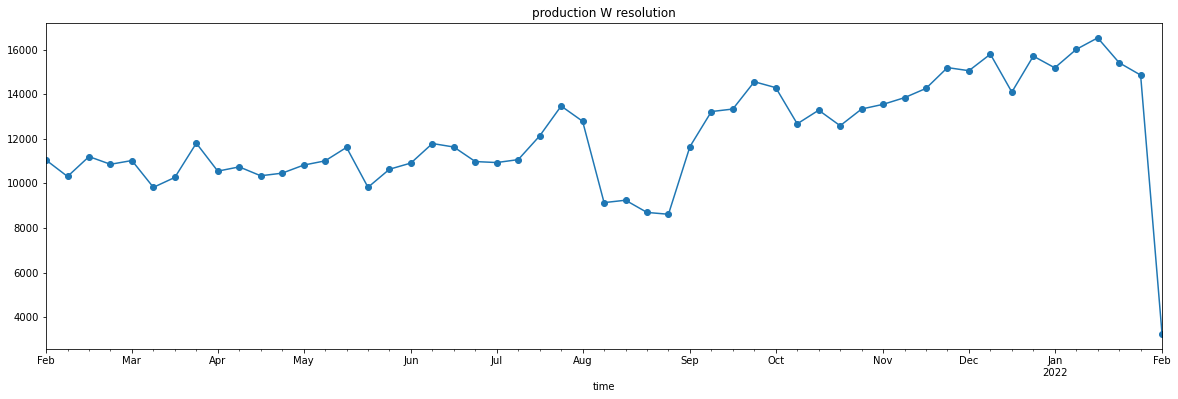

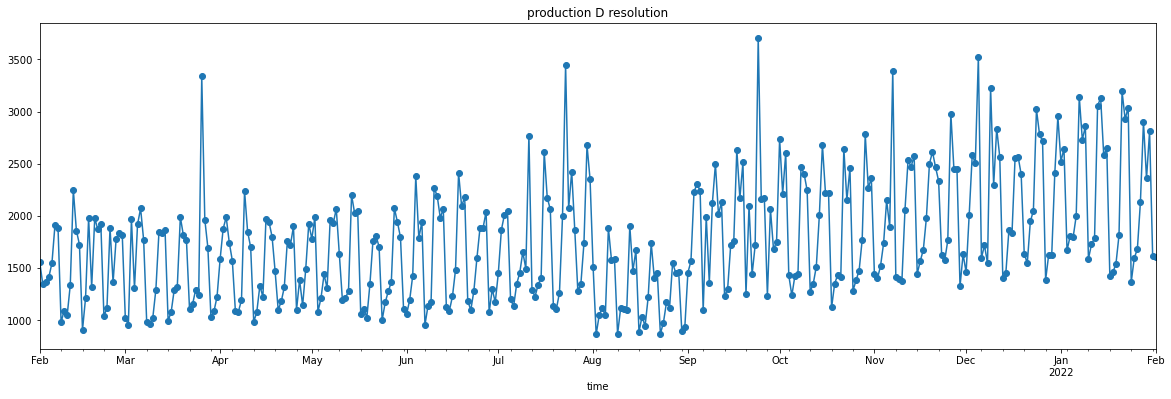

In [8]:
for resolution in ['M', 'W', 'D']:
    fig, ax = plt.subplots(figsize=(20, 6))
    df['orders'].resample(resolution).sum().plot(ax=ax, marker='o')
    ax.set_title(f'production {resolution} resolution')

We can see that on the period of the data, the orders tend to increase slightly. There is a clearly decrease in the orders duing August (holiday period).

The graph above also let us know the attypical demand of orders on three specific dates: March 26, July 23 and September 24.

In [9]:
df.loc[df['orders']>800]

orders city
time                            
2021-03-26 21:00:00   846.0  BCN
2021-07-23 21:00:00   873.0  BCN
2021-09-24 21:00:00   939.0  BCN

Other important dates

In [10]:
df_d = df['orders'].resample('D').sum().to_frame().reset_index()
px.line(df_d, x="time", y="orders", title="Globo orders by day (BCN)")

November 7 and December 5 were also days on which the orders show an atypical behaviour.

Orders by day of the weak and hour of the day

In [11]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday

#sns.boxplot(x = 'hour', y = 'orders', data=df) 
px.box(df, x="hour", y="orders", title = 'Orders by hour of the day')

In [12]:
px.box(df, x="weekday", y="orders", title = 'Orders by day of the week')

Midday hours and night (20 to 22 hours) are the most popular hours for orders. On the other hand, Friday is the day in which people order more on Glovo.

Graph of orders per hour of the day and day of the week.

In [13]:
# Data for the het map
df_ = df.copy()
df_['Week Day'] = df.index.day_name()

df_tab = df_.groupby(['Week Day', 'hour'])['orders'].mean().reset_index()
df_tab = df_tab.pivot(index='Week Day', columns='hour')
df_tab.columns = [hour for hour in range(24)]

<AxesSubplot:ylabel='Week Day'>

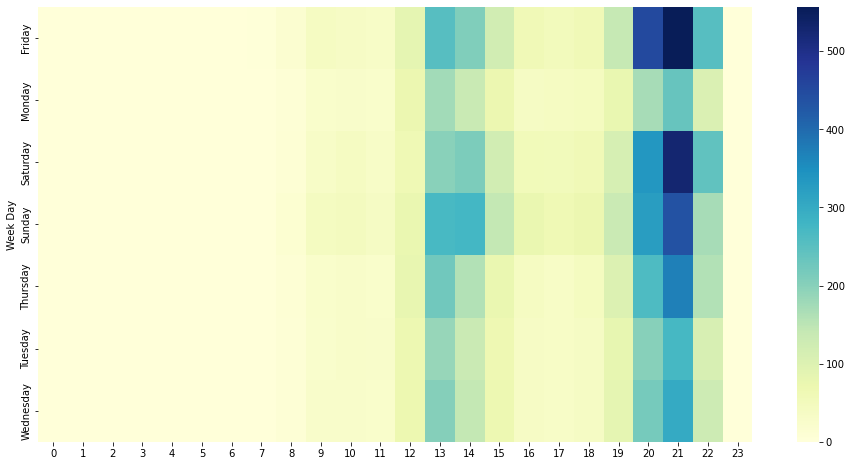

In [14]:
# Heat map
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(df_tab, cmap="YlGnBu")

Friday and Saturday at 9 p.m are the peaked times for orders during the week

Lets see now by month there are changes in the day and hour at which customers order 

<AxesSubplot:ylabel='Month'>

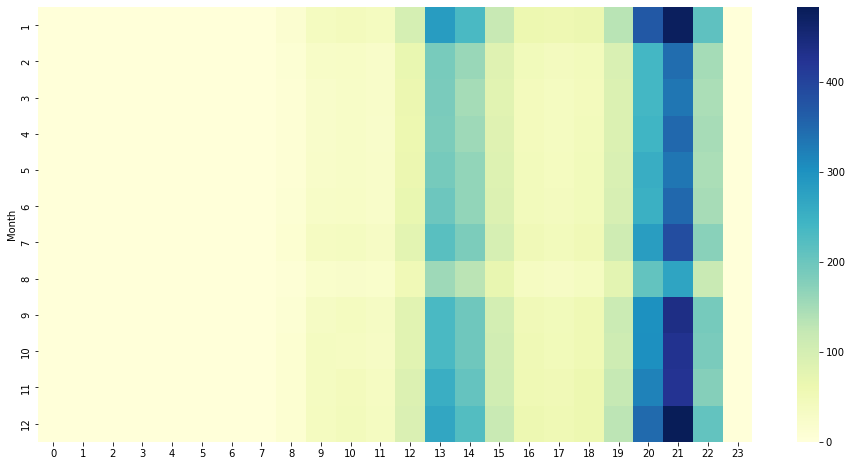

In [15]:
df_['Month'] = df.index.month

df_tab = df_.groupby(['Month', 'hour'])['orders'].mean().reset_index()
df_tab = df_tab.pivot(index='Month', columns='hour')
df_tab.columns = [hour for hour in range(24)]

# Heat map
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(df_tab, cmap="YlGnBu")

As seen before August in the month in which people order less on Glovo. The number of orders increases in December and January at the 20 hours

<AxesSubplot:xlabel='None-Week Day', ylabel='Month'>

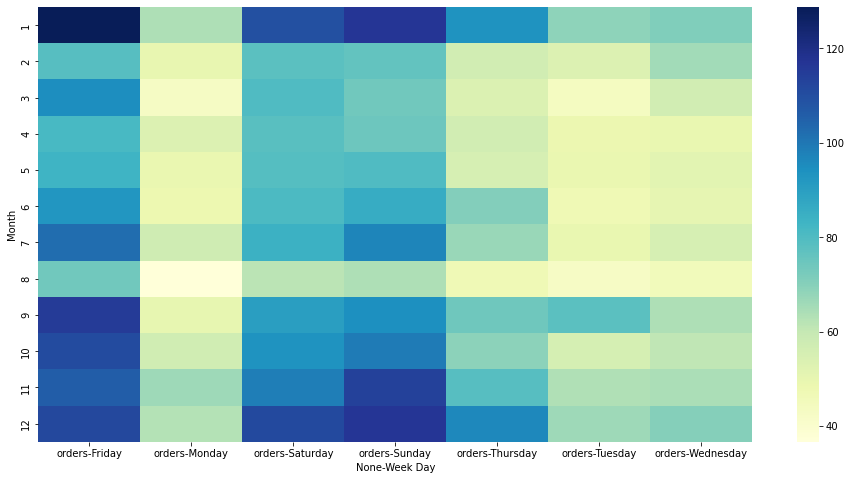

In [16]:
df_['Month'] = df.index.month

df_tab = df_.groupby(['Month', 'Week Day'])['orders'].mean().reset_index()
df_tab = df_tab.pivot(index='Month', columns='Week Day')

# Heat map
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(df_tab, cmap="YlGnBu")

It is interesting to se that on November, December and January there is a high demand for orders on Sundays. On thos month the number of orders on monday is also higher in comparison with other months

Since we need to predict by week (next week) we create a id variable for the week

In [17]:
# Creation a id of week (0 for the first week in the data, 1 for the next and so on)
df = df.copy()
df['week_id'] = df.index.isocalendar().week 
df['week_id'] = np.where((df.index.year == 2022) & (df['week_id'] < 52), df['week_id'] + 52, df['week_id']) - 5
print(df['week_id'].min(), df['week_id'].max())

0 52


In [19]:
# Last week is incomplete only has data for Monday and Tuesday
df = df[(df['week_id'] != 52)]

In [20]:
# Three weeks with less values (no data on monday between 0 and 5 hours): 
# easy to impute since always there are 0 orders at those hours
missing_data = []
for week in [2, 18, 37]:
    for hour in range(6):
        date = df[(df['week_id'] == week) & (df['weekday'] == 0)].index.max()
        missing_data.append( {'time': date + timedelta(hours = hour + 1),
                              'orders': 0,
                              'city': 'BCN',
                              'hour': hour,
                              'weekday': 0,
                              'week_id': week}
                           )

anex = pd.DataFrame(missing_data).set_index('time')

# Append and sort by date
df = pd.concat([df, anex]).sort_index()

So far we have discovered that:

- The number of orders follows a right skewed distribution
- Trends observed:
    - Overall the number of orders tends to increase with the time (app usage growth)
    - On the week the number of orders increases with as the week ends
    
- The seasonalities observed are: 
    - During the period of holidays there are less orders
    - Fridays and Saturdays at 9 pm the orders the peaked
    - Orders tend to increase on the days around Friday
    
- A typical day of Glovo orders is: no orders until 6 am, then the orders increase slighly until midday when we see the firs peak, then during the afternoon hours there are few orders and from 7 pm the orders start to increase reaching a maximun at 9 pm.

- The atypical points we observed are March 26, July 23 and September 24


# Modelling



In [21]:
from sklearn.metrics import mean_squared_error as MSE

def SMAPE(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

## Naive base line model

Given that every Sunday at night we will predict the orders of the coming week, a naive but still logic way to predict is to use the observed values of week that is finishing. Lets do this a check the performance of this approach.

In [113]:
# The last week of the data is incomplete only 2 days and can give some issues
df_naive = df.copy()
df_naive.reset_index(inplace=True)

In [114]:
def ObservedLastWeek(X_train, X_test, y_train):
    predictions = []
    for row in X_test.index:
        day = X_test['weekday'][row]
        hour = X_test['hour'][row]
        week = X_test['week_id'][row]

        # The prediction in the number of orders at the same weekday and same hour in the previous week
        idx_ = X_train[(X_train['weekday'] == day) & (X_train['hour'] == hour) & (X_train['week_id'] == week - 1)].index
        predicted_point  = [i for i in y_train.iloc[idx_]][0]

        predictions.append(predicted_point)
    
    return predictions

In [115]:
# Cross validation of this naive approach over ten time series splits

ts_splits = TimeSeriesSplit(n_splits = 10, test_size = 168) # ten splits where each test set has the 168 hours of the week

target = 'orders'

results = []
iter_ = 0
for train_idx, val_idx in ts_splits.split(df_naive):
    X_train, y_train, = df_naive.iloc[train_idx].drop(target, axis=1), df_naive.iloc[train_idx][target]
    X_val, y_val, = df_naive.iloc[val_idx].drop(target, axis=1), df_naive.iloc[val_idx][target]
    
    pred = ObservedLastWeek(X_train, X_val, y_train)
    
    iter_ += 1
    results.append({'iter': iter_,
                    'MSE' : MSE(y_val, pred),
                    'SMAPE': SMAPE(y_val, pred)})
    
results = pd.DataFrame(results)
print('Average MSE:', results['MSE'].mean(), 'Standard deviation MSE:', results['MSE'].std())
print('Average SMAPE:', results['SMAPE'].mean(), 'Standard deviation SMAPE:', results['SMAPE'].std())
   

Average MSE: 1578.1630952380951 Standard deviation MSE: 584.8252539705522
Average SMAPE: 30.272287114682722 Standard deviation SMAPE: 6.483793347515558


In [116]:
# Plot of the predicted values
predictions = []
for week in range(1,52):
    next_week = df_naive[df_naive['week_id'] == week + 1] # week to predict
    actual_previous = df_naive[df_naive['week_id'] <= week] # Weeks to use as training
    
    pred = ObservedLastWeek(actual_previous, next_week, actual_previous[target])
    predictions.append(pred)

predictions = [item for sublist in predictions for item in sublist]

df_naive_pred = df_naive[df_naive['week_id']>=1].copy()
df_naive_pred['predictions'] = predictions

<AxesSubplot:xlabel='time', ylabel='orders'>

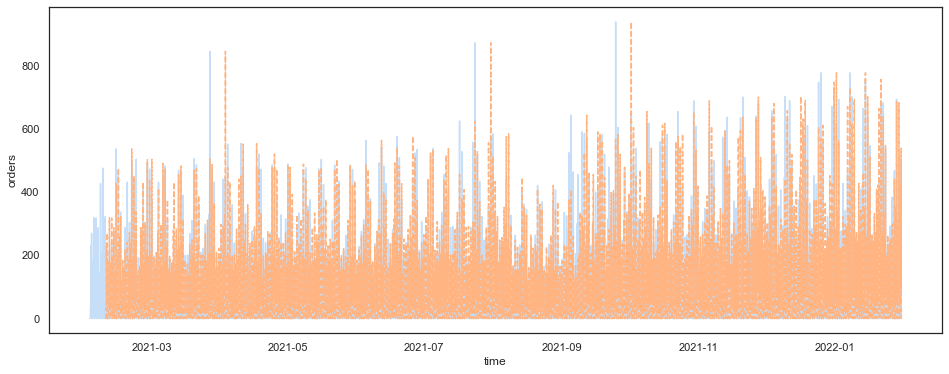

In [117]:
#sns.set_theme(style="white", palette="pastel")

fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(data = df_naive, x = 'time', y = 'orders', alpha = 0.6)
sns.lineplot(data = df_naive_pred, x = 'time', y = 'predictions', linestyle='--')

## ARIMA

Lets try now, our first model using for time series ARIMA. Here we reproduce what the decision process is, in this case every week the decision maker runs an ARIMA model to select the the resources for the next week, given that every weekend she has more data, every Sunday she explore what are the best parameters of the ARIMA model. Here we will use the function Autoarima  from the package `pmdarima`. 

Once more to we perfomr time series cross-validation for the last 10 weeks. 

In [150]:
# A dataframe wiht only the data about orders and time
df_arima = df[['orders', 'week_id']].copy()
train_arima = df_arima[df_arima['week_id'] < 42].drop('week_id', axis=1) # Train without the last 10 weeks

In [135]:
# Times series cross validation
ts_splits = TimeSeriesSplit(n_splits = 10, test_size = 168) # ten splits where each test set has the 168 hours of the week

target = 'orders'

results = []
iter_ = 0
for train_idx, val_idx in ts_splits.split(df_arima):
    X_train, y_train, = df_arima.iloc[train_idx].drop(target, axis=1), df_arima.iloc[train_idx][target]
    X_val, y_val, = df_arima.iloc[val_idx].drop(target, axis=1), df_arima.iloc[val_idx][target]
    
    arima_model = auto_arima(train_arima, start_p=0, start_q=0) # Each week search for the best arima model
    pred = arima_model.predict(168)
    
    iter_ += 1
    results.append({'iter': iter_,
                    'MSE' : MSE(y_val, pred),
                    'SMAPE': SMAPE(y_val, pred)})
    
results = pd.DataFrame(results)
print('Average MSE:', results['MSE'].mean(), 'Standard deviation MSE:', results['MSE'].std())
print('Average SMAPE:', results['SMAPE'].mean(), 'Standard deviation SMAPE:', results['SMAPE'].std())
   

Average MSE: 18230.90488180906 Standard deviation MSE: 1659.3239083146022
Average SMAPE: 120.5724588330198 Standard deviation SMAPE: 1.0283281058789797


The values of MSE and SMAPE are quite bad in comparison with the naive approach of using the values observed in the las week.

In [148]:
# Plot of the predicted values
predictions = []
for week in range(10,52):
    next_week = df_arima[df_arima['week_id'] == week + 1] # week to predict
    actual_previous = df_arima[df_arima['week_id'] <= week] # Weeks to use as training
    
    arima_model = ARIMA(actual_previous['orders'], order=(4, 1, 3)).fit()
    pred = arima_model.forecast(168) # Forecast the next 168 hours
    
    predictions.append(pred)

predictions = [item for sublist in predictions for item in sublist]

df_arima_pred = df_arima[df_arima['week_id'] >= 10].copy()
df_arima_pred['predictions'] = predictions

<AxesSubplot:xlabel='time', ylabel='orders'>

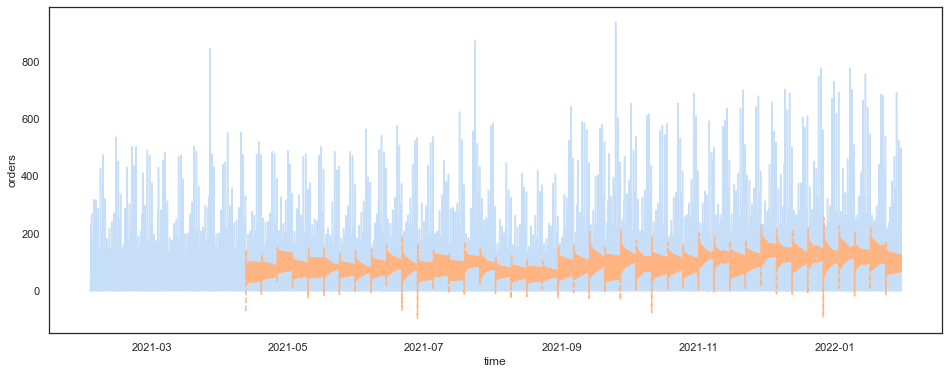

In [149]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(data = df_arima.reset_index(), x = 'time', y = 'orders', alpha = 0.6)
sns.lineplot(data = df_arima_pred.reset_index(), x = 'time', y = 'predictions', linestyle='--')

The ARIMA-predicted values look very strange wich makes seen after seing that poor performance on the MSE and SMAPE.

##  Random forest

Here we will use and create new variables to improve the predictions. Under the hypotesis that the course of the pandemy and the holidays affects the demand for glovo's orders we will try to include this in the next models.

### Feature creation

In [23]:
#!pip install holidays

In [25]:
from datetime import date
import holidays

In [26]:
# get the holidays of cataluña
cat_holidays = holidays.country_holidays('ES', subdiv='CT')

In [27]:
#getting the holidays for 2021 and 2022
cat_holidays.get('2021-01-01') 
cat_holidays.get('2022-01-01')
#defining fest_days as the festivities in our period of time 02/2021-02/2022
#creating a dataframe with the festivity days
fest_days = (pd.Series(list(cat_holidays.keys()), name='date').to_frame()).iloc[2:16].reset_index(drop=True)
#adding a festivity dummy
fest_days['fest_dum'] = 1
#adding a long_weekend column full of 0 that we will modify afterwards to mark long weekends (fri-sat-sun or sat-sun-mon)
fest_days['long_weekend'] = 0
#modifying long_weekend variable 1 if the dates for the festivities are friday or monday
fest_days['long_weekend'].iloc[0] = 1
fest_days['long_weekend'].iloc[1] = 1
fest_days['long_weekend'].iloc[6] = 1
fest_days['long_weekend'].iloc[7] = 1
fest_days

date  fest_dum  long_weekend
0   2021-04-02         1             1
1   2021-04-05         1             1
2   2021-05-01         1             0
3   2021-06-24         1             0
4   2021-08-16         1             0
5   2021-10-12         1             0
6   2021-11-01         1             1
7   2021-12-06         1             1
8   2021-12-08         1             0
9   2021-12-25         1             0
10  2021-12-27         1             0
11  2021-09-11         1             0
12  2022-01-01         1             0
13  2022-01-06         1             0

In [28]:
#filling the dates of the long weekend with 1s
data = {"date": (date(2021, 4, 3), date(2021, 4, 4), date(2021, 10, 31), date(2021, 10, 30), date(2021, 12, 5), date(2021, 12, 4)),
            "fest_dum": (0, 0, 0, 0, 0, 0),
            "long_weekend": (1,1,1,1,1,1)
           }

data = pd.DataFrame(data)

In [29]:
fest_days = fest_days.append(data).reset_index(drop=True)
fest_days

date  fest_dum  long_weekend
0   2021-04-02         1             1
1   2021-04-05         1             1
2   2021-05-01         1             0
3   2021-06-24         1             0
4   2021-08-16         1             0
5   2021-10-12         1             0
6   2021-11-01         1             1
7   2021-12-06         1             1
8   2021-12-08         1             0
9   2021-12-25         1             0
10  2021-12-27         1             0
11  2021-09-11         1             0
12  2022-01-01         1             0
13  2022-01-06         1             0
14  2021-04-03         0             1
15  2021-04-04         0             1
16  2021-10-31         0             1
17  2021-10-30         0             1
18  2021-12-05         0             1
19  2021-12-04         0             1

In [30]:
df.head()

orders city  hour  weekday week_id
time                                                   
2021-02-01 00:00:00     0.0  BCN     0        0       0
2021-02-01 01:00:00     0.0  BCN     1        0       0
2021-02-01 02:00:00     0.0  BCN     2        0       0
2021-02-01 03:00:00     0.0  BCN     3        0       0
2021-02-01 04:00:00     0.0  BCN     4        0       0

In [31]:
#merging both dataframes in df
df['date'] = df.index.date
df_m = pd.merge(df.reset_index(), fest_days, on='date', how='left')
df_m['fest_dum'] = df_m['fest_dum'].fillna(0)
df_m['long_weekend'] = df_m['long_weekend'].fillna(0)

In [32]:
#filling fest_dum also with a 1 if it's saturday or sunday
for i in df_m['fest_dum']:
    if df_m['week_id'][i] == 5 or 6:
        df_m['fest_dum'][i] = 1

In [33]:
df_m['time'].dt.quarter

0       1
1       1
2       1
3       1
4       1
       ..
8731    1
8732    1
8733    1
8734    1
8735    1
Name: time, Length: 8736, dtype: int64

In [34]:
# More variables of dates
df_m['quarter'] = df_m['time'].dt.quarter
df_m['month'] = df_m['time'].dt.month
df_m['dayofyear'] = df_m['time'].dt.dayofyear
df_m['dayofmonth'] = df_m['time'].dt.day
df_m['weekofyear'] = df_m['time'].dt.weekofyear

In [35]:
# Var of lagged values
df_m['orders_6_hrs_lag'] = df_m['orders'].shift(6).replace(np.nan, 0)
df_m['orders_12_hrs_lag'] = df_m['orders'].shift(12).replace(np.nan, 0)
df_m['orders_24_hrs_lag'] = df_m['orders'].shift(24).replace(np.nan, 0)

In [36]:
df_m.drop(['city', 'date'], axis=1, inplace=True)
df_m.set_index('time', inplace=True)
df_m['week_id'] = df_m['week_id'].astype(int)
df_m.head()

orders  hour  weekday  week_id  fest_dum  long_weekend  \
time                                                                          
2021-02-01 00:00:00     0.0     0        0        0       1.0           0.0   
2021-02-01 01:00:00     0.0     1        0        0       1.0           0.0   
2021-02-01 02:00:00     0.0     2        0        0       0.0           0.0   
2021-02-01 03:00:00     0.0     3        0        0       0.0           0.0   
2021-02-01 04:00:00     0.0     4        0        0       0.0           0.0   

                     quarter  month  dayofyear  dayofmonth  weekofyear  \
time                                                                     
2021-02-01 00:00:00        1      2         32           1           5   
2021-02-01 01:00:00        1      2         32           1           5   
2021-02-01 02:00:00        1      2         32           1           5   
2021-02-01 03:00:00        1      2         32           1           5   
2021-02-01 04:00:00        1      2         32           1           5   

                     orders_6_hrs_lag  orders_12_hrs_lag  orders_24_hrs_lag  
time                                                                         
2021-02-01 00:00:00               0.0                0.0                0.0  
2021-02-01 01:00:00               0.0                0.0                0.0  
2021-02-01 02:00:00               0.0                0.0                0.0  
2021-02-01 03:00:00               0.0                0.0                0.0  
2021-02-01 04:00:00               0.0                0.0                0.0

In [78]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8736 entries, 2021-02-01 00:00:00 to 2022-01-30 23:00:00
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   orders             8736 non-null   float64
 1   hour               8736 non-null   int64  
 2   weekday            8736 non-null   int64  
 3   week_id            8736 non-null   object 
 4   fest_dum           8736 non-null   float64
 5   long_weekend       8736 non-null   float64
 6   quarter            8736 non-null   int64  
 7   month              8736 non-null   int64  
 8   dayofyear          8736 non-null   int64  
 9   dayofmonth         8736 non-null   int64  
 10  weekofyear         8736 non-null   int64  
 11  orders_6_hrs_lag   8736 non-null   float64
 12  orders_12_hrs_lag  8736 non-null   float64
 13  orders_24_hrs_lag  8736 non-null   float64
dtypes: float64(6), int64(7), object(1)
memory usage: 1023.8+ KB


### Grid search and predictions

Let's run a small grid search in the Random Forest model

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
# Function for times series cross validation

def cross_val_ts(df, model, target):
    ts_splits = TimeSeriesSplit(n_splits = 10, test_size = 168) # ten splits where each test set has the 168 hours of the week

    results = []
    iter_ = 0
    
    
    for train_idx, val_idx in ts_splits.split(df):
        X_train, y_train, = df.iloc[train_idx].drop(target, axis=1), df.iloc[train_idx][target]
        X_val, y_val, = df.iloc[val_idx].drop(target, axis=1), df.iloc[val_idx][target]

        model.fit(X_train, y_train)
        
        pred = model.predict(X_val)

        iter_ += 1
        results.append({'iter': iter_,
                        'MSE' : MSE(y_val, pred),
                        'SMAPE': SMAPE(y_val, pred)})

    results =  pd.DataFrame(results)
    print('Average MSE:', results['MSE'].mean(), 'Standard deviation MSE:', results['MSE'].std())
    print('Average SMAPE:', results['SMAPE'].mean(), 'Standard deviation SMAPE:', results['SMAPE'].std(), '\n')
   
    return pd.DataFrame(results)
    

In [39]:
# Grid search
cross_params = {'n_estimators' : [10, 100, 300],
               'max_depth' : [2, 5, 7]}

for estimators in cross_params['n_estimators']:
    for depth in cross_params['max_depth']:
        print('Estimators:',estimators, 'depth:', depth, '\n')
        cross_val_ts(df_m, RandomForestRegressor(n_estimators = estimators, max_depth = depth), 'orders')

Estimators: 10 depth: 2 

Average MSE: 4354.794523587912 Standard deviation MSE: 808.8079192165411
Average SMAPE: 97.509990644454 Standard deviation SMAPE: 2.6618290479293414 

Estimators: 10 depth: 5 

Average MSE: 2147.664481337617 Standard deviation MSE: 586.5341497701095
Average SMAPE: 83.94957559081038 Standard deviation SMAPE: 2.520957365820244 

Estimators: 10 depth: 7 

Average MSE: 1472.3474966763351 Standard deviation MSE: 595.046517480616
Average SMAPE: 64.26089965594528 Standard deviation SMAPE: 21.322447510296943 

Estimators: 100 depth: 2 

Average MSE: 4358.665694966944 Standard deviation MSE: 821.1066779819162
Average SMAPE: 97.82921605819027 Standard deviation SMAPE: 2.6780340547010955 

Estimators: 100 depth: 5 

Average MSE: 2047.2159832343987 Standard deviation MSE: 472.64674346764633
Average SMAPE: 83.40287670933535 Standard deviation SMAPE: 2.2993537474474026 

Estimators: 100 depth: 7 

Average MSE: 1347.4007192578179 Standard deviation MSE: 397.47070881843337
Av

In [53]:
# Plot of the predicted values using the best parameters from the grid search
predictions = []
for week in range(10,51):
    next_week = df_m[df_m['week_id'] == week + 1] # week to predict
    actual_previous = df_m[df_m['week_id'] <= week] # Weeks to use as training
    
    rf = RandomForestRegressor(n_estimators = 100, max_depth = 7)
    rf.fit(actual_previous.drop(['orders'],axis=1), actual_previous['orders'])
    pred = rf.predict(next_week.drop(['orders'], axis=1)) # Forecast the next 168 hours
    predictions.append(pred)

predictions = [item for sublist in predictions for item in sublist]

df_m_pred = df_m[df_m['week_id'] > 10].copy()
df_m_pred['predictions'] = predictions

<AxesSubplot:xlabel='time', ylabel='orders'>

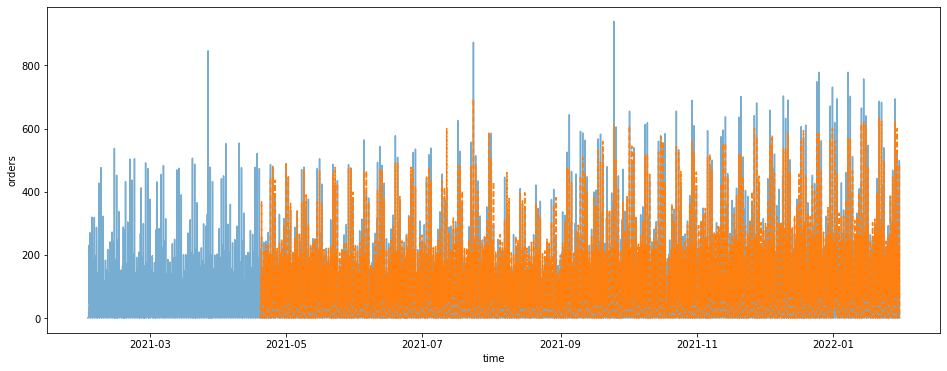

In [54]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(data = df_m.reset_index(), x = 'time', y = 'orders', alpha = 0.6)
sns.lineplot(data = df_m_pred.reset_index(), x = 'time', y = 'predictions', linestyle='--')

In this case, the Random Forest is the best model when taking into account the MSE. However the naive approach is better in the SMAPE metric